In [1]:
from datetime import datetime
from sklearn.metrics import roc_auc_score, plot_roc_curve

import json
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 1000)

import mysql.connector
import seaborn as sns
from datetime import date
from datetime import datetime
from datetime import timedelta

from getpass import getpass
import os
import glob
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn, optim

import torch.nn.functional as F
import math, copy, time
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from itertools import cycle
from tqdm.notebook import tqdm
import re
from sklearn.metrics import roc_auc_score, plot_roc_curve, roc_curve

import matplotlib.pyplot as plt
import seaborn
from collections import defaultdict
import shap

from sklearn import svm

In [2]:
## server config

### md_data에 location 필드 넣어서, 당시 gps 해당 주소 넣어준 csv 불러옴

In [3]:
# df_md_data_location = pd.read_csv('md_data_with_location.csv')
df_md_data_location = pd.read_csv('md_data_with_location_20221018.csv')

Columns (13,20,23) have mixed types.Specify dtype option on import or set low_memory=False.


In [4]:
df_md_data_location.shape[0]

2169071

In [5]:
df_md_data_location.head()

,Unnamed: 0,_id,baby_id,app_code,group_id,type,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,lat,lng,rewarded,sent,bc_offset,weight,memo,date,last_update_de,reg_date,is_test,is_delete,location
0,0,2296896,34407,200,NaN,205,2022-10-18,"4=104,10=1","5=1,5-1=2022-03-12,5-3=7",NaN,1_2022-03-12_0_7,216,"{""final-instruction-category"":"""",""final-instru...",NaN,35.952943,127.015066,N,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 00:00:00,2022-10-18 09:15:25,0,0,대한민국 전라북도 익산시 석암동
1,1,2296895,40867,200,NaN,205,2022-10-18,10=1,"5=1,6=1,5-1=2022-03-16,5-3=undefined",NaN,1_2022-03-16_0_undefined,214,"{""final-instruction-category"":null,""final-inst...",NaN,35.143311,126.929534,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:21,2022-10-18 09:15:21,0,0,대한민국 광주광역시 동구 서남동
2,2,2296894,31371,200,NaN,120,2022-10-17,1,순천시보건소,NaN,"[""https://file.fevermanager.com/shine/Files/PC...",NaN,NaN,NaN,34.943935,127.501361,P,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:07,2022-10-18 09:15:07,0,0,대한민국 전라남도 순천시 풍덕동
3,3,2296893,66965,200,NaN,205,2022-10-18,10=1,"6=1,6-90=1",NaN,NaN,33,"{""final-instruction-category"":"""",""final-instru...",NaN,35.160509,126.883790,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:05,2022-10-18 09:15:05,0,0,대한민국 광주광역시 서구 농성1동
4,4,2296892,26644,200,NaN,205,2022-10-18,"4=107,5=가래,10=1","5=1,5-1=2022-04-01,5-3=undefined",NaN,1_2022-04-01_0_undefined,201,"{""final-instruction-category"":"""",""final-instru...",NaN,35.210338,128.649659,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:00,2022-10-18 09:15:00,0,0,대한민국 경상남도 창원시 성산구


In [6]:
df_md_data_location

,Unnamed: 0,_id,baby_id,app_code,group_id,type,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,lat,lng,rewarded,sent,bc_offset,weight,memo,date,last_update_de,reg_date,is_test,is_delete,location
0,0,2296896,34407,200,NaN,205,2022-10-18,"4=104,10=1","5=1,5-1=2022-03-12,5-3=7",NaN,1_2022-03-12_0_7,216,"{""final-instruction-category"":"""",""final-instru...",NaN,35.952943,127.015066,N,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 00:00:00,2022-10-18 09:15:25,0,0,대한민국 전라북도 익산시 석암동
1,1,2296895,40867,200,NaN,205,2022-10-18,10=1,"5=1,6=1,5-1=2022-03-16,5-3=undefined",NaN,1_2022-03-16_0_undefined,214,"{""final-instruction-category"":null,""final-inst...",NaN,35.143311,126.929534,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:21,2022-10-18 09:15:21,0,0,대한민국 광주광역시 동구 서남동
2,2,2296894,31371,200,NaN,120,2022-10-17,1,순천시보건소,NaN,"[""https://file.fevermanager.com/shine/Files/PC...",NaN,NaN,NaN,34.943935,127.501361,P,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:07,2022-10-18 09:15:07,0,0,대한민국 전라남도 순천시 풍덕동
3,3,2296893,66965,200,NaN,205,2022-10-18,10=1,"6=1,6-90=1",NaN,NaN,33,"{""final-instruction-category"":"""",""final-instru...",NaN,35.160509,126.883790,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:05,2022-10-18 09:15:05,0,0,대한민국 광주광역시 서구 농성1동
4,4,2296892,26644,200,NaN,205,2022-10-18,"4=107,5=가래,10=1","5=1,5-1=2022-04-01,5-3=undefined",NaN,1_2022-04-01_0_undefined,201,"{""final-instruction-category"":"""",""final-instru...",NaN,35.210338,128.649659,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:00,2022-10-18 09:15:00,0,0,대한민국 경상남도 창원시 성산구
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169066,2169066,5,6,200,2.021012e+13,1,36.7,C,NaN,1,NaN,NaN,NaN,NaN,37.545864,126.870728,N,N,NaN,0.0,NaN,2021-01-22 21:07:31,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동
2169067,2169067,4,6,200,2.021012e+13,3,0_2_0_0_0_0_0_0_0_0-CV048,1,NaN,NaN,NaN,NaN,NaN,NaN,37.545864,126.870728,N,N,NaN,0.0,NaN,2021-01-22 21:07:32,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동
2169068,2169068,3,6,200,NaN,202,2021-09-27,0,"3=3,7=1,7-1=2021-08-07",NaN,NaN,NaN,NaN,NaN,37.545822,126.870834,N,N,NaN,0.0,NaN,2021-01-22 21:08:17,2021-09-27 15:07:20,NaN,0,0,대한민국 서울특별시 양천구 목동
2169069,2169069,2,6,200,2.021012e+13,102,0,NaN,0,NaN,NaN,"303-2,305-4",0,NaN,37.545597,126.870934,N,N,NaN,0.0,NaN,2021-01-22 21:07:31,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동


In [7]:
df_md_data_location.shape[0]

2169071

### 샤인데이터에 들어있는 시군구 리스트 이름 뽑아와서 주소를 시군구로 바꿔주는 작업

In [8]:
df_sigungu_name = pd.read_csv('sigungu_name.csv')

In [9]:
df_sigungu_name

,sido,sigungu
0,서울,강남구
1,서울,강동구
2,서울,강북구
3,서울,강서구
4,서울,관악구
5,서울,광진구
6,서울,구로구
7,서울,금천구
8,서울,노원구
9,서울,도봉구


In [10]:
sigungu_dict = {}
for addr_1, addr_2 in df_sigungu_name.values:
    if addr_1 not in sigungu_dict:
        sigungu_dict[addr_1] = []
    sigungu_dict[addr_1].append(addr_2)
sigungu_dict

{'서울': ['강남구',
  '강동구',
  '강북구',
  '강서구',
  '관악구',
  '광진구',
  '구로구',
  '금천구',
  '노원구',
  '도봉구',
  '동대문구',
  '동작구',
  '마포구',
  '서대문구',
  '서초구',
  '성동구',
  '성북구',
  '송파구',
  '양천구',
  '영등포구',
  '용산구',
  '은평구',
  '종로구',
  '중구',
  '중랑구',
  '기타'],
 '대구': ['대구'],
 '인천': ['중구',
  '동구',
  '미추홀구',
  '연수구',
  '남동구',
  '부평구',
  '계양구',
  '서구',
  '강화군',
  '옹진군',
  '기타'],
 '경기': ['수원',
  '고양',
  '용인',
  '성남',
  '부천',
  '안산',
  '화성',
  '남양주',
  '안양',
  '평택',
  '의정부',
  '파주',
  '시흥',
  '김포',
  '광명',
  '광주',
  '군포',
  '이천',
  '오산',
  '하남',
  '양주',
  '구리',
  '안성',
  '포천',
  '의왕',
  '여주',
  '양평',
  '동두천',
  '과천',
  '가평',
  '연천'],
 '강원': ['춘천',
  '원주',
  '강릉',
  '동해',
  '태백',
  '속초',
  '삼척',
  '홍천',
  '횡성',
  '영월',
  '평창',
  '정선',
  '철원',
  '화천',
  '양구',
  '인제',
  '고성',
  '양양'],
 '충북': ['단양군',
  '제천시',
  '충주시',
  '음성군',
  '괴산군',
  '증평군',
  '진천군',
  '청주시',
  '보은군',
  '옥천군',
  '영동군'],
 '충남': ['천안',
  '공주',
  '보령',
  '아산',
  '서산',
  '논산',
  '계룡',
  '당진',
  '금산',
  '부여',
  '서천',
  '청양',
  '홍성',
  '예산',
  '태안',

In [11]:
def apply_and_concat(df, field, func, cols_name):
    return pd.concat((df, df[field].apply(lambda cell: pd.Series(func(cell), index=cols_name))), axis=1)

In [12]:
def make_sidosigungu(location):
    sido = ''
    sigungu = ''
    if type(location) == float:
        return sido, sigungu
    for addr1 in sigungu_dict:
        if addr1 in location:
            sido = addr1
            for addr2 in sigungu_dict[addr1]:
                if addr2 in location:
                    sigungu = addr2
    return sido, sigungu

In [13]:
cols_name = ['sido', 'sigungu']
df_md_data_location_latest = apply_and_concat(df_md_data_location, 'location', make_sidosigungu, cols_name)

In [14]:
df_md_data_location_latest

,Unnamed: 0,_id,baby_id,app_code,group_id,type,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,lat,lng,rewarded,sent,bc_offset,weight,memo,date,last_update_de,reg_date,is_test,is_delete,location,sido,sigungu
0,0,2296896,34407,200,NaN,205,2022-10-18,"4=104,10=1","5=1,5-1=2022-03-12,5-3=7",NaN,1_2022-03-12_0_7,216,"{""final-instruction-category"":"""",""final-instru...",NaN,35.952943,127.015066,N,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 00:00:00,2022-10-18 09:15:25,0,0,대한민국 전라북도 익산시 석암동,,
1,1,2296895,40867,200,NaN,205,2022-10-18,10=1,"5=1,6=1,5-1=2022-03-16,5-3=undefined",NaN,1_2022-03-16_0_undefined,214,"{""final-instruction-category"":null,""final-inst...",NaN,35.143311,126.929534,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:21,2022-10-18 09:15:21,0,0,대한민국 광주광역시 동구 서남동,광주,동구
2,2,2296894,31371,200,NaN,120,2022-10-17,1,순천시보건소,NaN,"[""https://file.fevermanager.com/shine/Files/PC...",NaN,NaN,NaN,34.943935,127.501361,P,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:07,2022-10-18 09:15:07,0,0,대한민국 전라남도 순천시 풍덕동,,
3,3,2296893,66965,200,NaN,205,2022-10-18,10=1,"6=1,6-90=1",NaN,NaN,33,"{""final-instruction-category"":"""",""final-instru...",NaN,35.160509,126.883790,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:05,2022-10-18 09:15:05,0,0,대한민국 광주광역시 서구 농성1동,광주,서구
4,4,2296892,26644,200,NaN,205,2022-10-18,"4=107,5=가래,10=1","5=1,5-1=2022-04-01,5-3=undefined",NaN,1_2022-04-01_0_undefined,201,"{""final-instruction-category"":"""",""final-instru...",NaN,35.210338,128.649659,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:00,2022-10-18 09:15:00,0,0,대한민국 경상남도 창원시 성산구,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2169066,2169066,5,6,200,2.021012e+13,1,36.7,C,NaN,1,NaN,NaN,NaN,NaN,37.545864,126.870728,N,N,NaN,0.0,NaN,2021-01-22 21:07:31,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동,서울,양천구
2169067,2169067,4,6,200,2.021012e+13,3,0_2_0_0_0_0_0_0_0_0-CV048,1,NaN,NaN,NaN,NaN,NaN,NaN,37.545864,126.870728,N,N,NaN,0.0,NaN,2021-01-22 21:07:32,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동,서울,양천구
2169068,2169068,3,6,200,NaN,202,2021-09-27,0,"3=3,7=1,7-1=2021-08-07",NaN,NaN,NaN,NaN,NaN,37.545822,126.870834,N,N,NaN,0.0,NaN,2021-01-22 21:08:17,2021-09-27 15:07:20,NaN,0,0,대한민국 서울특별시 양천구 목동,서울,양천구
2169069,2169069,2,6,200,2.021012e+13,102,0,NaN,0,NaN,NaN,"303-2,305-4",0,NaN,37.545597,126.870934,N,N,NaN,0.0,NaN,2021-01-22 21:07:31,2021-01-22 21:10:03,NaN,0,0,대한민국 서울특별시 양천구 목동,서울,양천구


### 이벤트 기간
- 1차: 2.28~4.4
- 2차: 8.16~10.30

### sido, sigungu 존재하는 데이터 갯수 체크

In [15]:
df_md_data_location_latest[(df_md_data_location_latest['sido'] == '') |  (df_md_data_location_latest['sigungu'] == '')].shape[0]

598422

In [16]:
df_md_data_location_latest[~((df_md_data_location_latest['sido'] == '') |  (df_md_data_location_latest['sigungu'] == ''))].shape[0]

1570649

### 시군구 가져올까한번?

In [17]:
# df_md_data_location_latest.to_csv('df_md_data_sigungu_20221018.csv')
df_md_data_location_latest = pd.read_csv('df_md_data_sigungu_20221018.csv')

Columns (14,21,24) have mixed types.Specify dtype option on import or set low_memory=False.


In [18]:
df_md_data_location_latest['sido'] = df_md_data_location_latest['sido'].fillna('')
df_md_data_location_latest['sigungu'] = df_md_data_location_latest['sigungu'].fillna('')

### 여기서 일단 sigungu 있는 애들만 따로 저장

In [19]:
df_mddata_with_sigungu = (df_md_data_location_latest[~((df_md_data_location_latest['sido'] == '') |  
                                                       (df_md_data_location_latest['sigungu'] == ''))])

In [20]:
# (df_mddata_with_sigungu.groupby(['sido']).size()).to_csv('sido_size.csv')

In [21]:
# ser_sido_sz = df_md_data_location_latest.groupby(['sido']).size()

In [22]:
# (ser_sido_sz / ser_sido_sz.sum()).to_csv('sido_ratio.csv')

In [23]:
# (df_mddata_with_sigungu.groupby(['sigungu']).size()).to_csv('sigungu_size.csv')

In [24]:
# ser_sigungu_sz = df_mddata_with_sigungu.groupby(['sigungu']).size()

In [25]:
# (ser_sigungu_sz / ser_sigungu_sz.sum()).sum()

In [26]:
# (ser_sigungu_sz / ser_sigungu_sz.sum()).to_csv('sigungu_ratio.csv')

In [27]:
# df_md_data_location_latest[['location', 'sido', 'sigungu']].to_csv('md_data_location_final.csv', index=False)

In [28]:
# df_mddata_with_sigungu.to_csv('df_mddata_with_sigungu.csv', index=False)

In [29]:
# df_mddata_with_sigungu = pd.read_csv('df_mddata_with_sigungu.csv')

In [30]:
df_md_data_location_latest.head()

,Unnamed: 0,Unnamed: 0.1,_id,baby_id,app_code,group_id,type,data_1,data_2,data_3,data_4,data_5,data_6,data_7,data_8,lat,lng,rewarded,sent,bc_offset,weight,memo,date,last_update_de,reg_date,is_test,is_delete,location,sido,sigungu
0,0,0,2296896,34407,200,NaN,205,2022-10-18,"4=104,10=1","5=1,5-1=2022-03-12,5-3=7",NaN,1_2022-03-12_0_7,216,"{""final-instruction-category"":"""",""final-instru...",NaN,35.952943,127.015066,N,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 00:00:00,2022-10-18 09:15:25,0,0,대한민국 전라북도 익산시 석암동,,
1,1,1,2296895,40867,200,NaN,205,2022-10-18,10=1,"5=1,6=1,5-1=2022-03-16,5-3=undefined",NaN,1_2022-03-16_0_undefined,214,"{""final-instruction-category"":null,""final-inst...",NaN,35.143311,126.929534,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:21,2022-10-18 09:15:21,0,0,대한민국 광주광역시 동구 서남동,광주,동구
2,2,2,2296894,31371,200,NaN,120,2022-10-17,1,순천시보건소,NaN,"[""https://file.fevermanager.com/shine/Files/PC...",NaN,NaN,NaN,34.943935,127.501361,P,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:07,2022-10-18 09:15:07,0,0,대한민국 전라남도 순천시 풍덕동,,
3,3,3,2296893,66965,200,NaN,205,2022-10-18,10=1,"6=1,6-90=1",NaN,NaN,33,"{""final-instruction-category"":"""",""final-instru...",NaN,35.160509,126.883790,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:05,2022-10-18 09:15:05,0,0,대한민국 광주광역시 서구 농성1동,광주,서구
4,4,4,2296892,26644,200,NaN,205,2022-10-18,"4=107,5=가래,10=1","5=1,5-1=2022-04-01,5-3=undefined",NaN,1_2022-04-01_0_undefined,201,"{""final-instruction-category"":"""",""final-instru...",NaN,35.210338,128.649659,Y,N,NaN,NaN,NaN,2022-10-18 00:00:00,2022-10-18 09:15:00,2022-10-18 09:15:00,0,0,대한민국 경상남도 창원시 성산구,,


### baby 정보 가져오기

In [31]:
df_md_baby = pd.read_csv('md_baby_new.csv')

In [32]:
df_md_baby.columns

Index(['baby_id', 'birthday', 'gender'], dtype='object')

In [33]:
df_md_baby = df_md_baby[~df_md_baby['gender'].isnull()]

In [34]:
df_md_baby['birthday'].apply(lambda x : x[:4]).unique()

array(['1993', '1966', '1994', '1995', '1989', '2002', '1981', '2008',
       '1986', '1991', '1985', '1983', '1943', '1979', '1999', '1997',
       '2007', '1982', '1976', '1987', '2006', '2001', '1958', '2005',
       '1992', '1996', '2003', '1972', '2000', '1973', '1953', '1984',
       '1959', '1980', '1970', '1955', '1990', '1975', '1977', '2004',
       '1978', '1988', '1998', '1968', '1944', '1971', '1965', '1963',
       '1954', '1974', '1960', '1962', '1961', '1956', '1969', '1952',
       '1946', '1964', '1967', '1951', '1949', '1947', '1957', '1938',
       '1948', '1945', '1950', '1941', '1942', '1932', '1936', '1939',
       '1940', '1935', '1930', '1929', '1937', '1927', '1934', '1933',
       '1928', '1931', '2013', '2012', '2009', '2010', '2011'],
      dtype=object)

In [35]:
df_md_baby['gender'] = df_md_baby['gender'].astype(int)

In [36]:
# del df_md_baby['Unnamed: 0']

In [37]:
def get_age(birthday):
    return datetime.now().year - int(birthday[:4])

In [38]:
df_md_baby['age'] = df_md_baby['birthday'].apply(get_age)

In [39]:
df_md_baby['age_60_and_above'] = df_md_baby['age'].apply(lambda age: 1 if age >= 60 else 0)

In [40]:
df_md_baby[df_md_baby['age_60_and_above'] == 1]

,baby_id,birthday,gender,age,age_60_and_above
18,67546,1943-09-13,1,79,1
37,67527,1958-09-20,0,64,1
77,67487,1953-10-14,1,69,1
79,67485,1959-09-08,0,63,1
88,67476,1955-11-19,1,67,1
...,...,...,...,...,...
63285,302,1962-01-15,0,60,1
63296,291,1961-01-13,0,61,1
63394,193,1962-04-24,0,60,1
63549,38,1958-02-08,0,64,1


### 시군구 넣어준 md_data에서 pcr 데이터랑 selfcheck 데이터 따로 뽑기

In [41]:
df_pcr = df_md_data_location_latest[df_md_data_location_latest['type'] == 120][['_id', 'baby_id', 'data_1', 'data_2', 'data_3', 'data_7', 'sido', 'sigungu']]
df_pcr.columns = ['_id', 'baby_id', 'pcr_date', 'pcr_result', 'pcr_place', 'is_confirmed', 'sido', 'sigungu']
df_selfcheck = df_md_data_location_latest[df_md_data_location_latest['type'] == 205]

In [42]:
df_pcr

,_id,baby_id,pcr_date,pcr_result,pcr_place,is_confirmed,sido,sigungu
2,2296894,31371,2022-10-17,1,순천시보건소,NaN,,
61,2296833,30328,2022-10-17,2,삼성더맑은이비인후과의원,NaN,서울,도봉구
67,2296827,47209,2022-10-17,1,경산보건소,NaN,,
2013,2294701,37855,2022-03-11,2,허종현 내과의원,NaN,부산,부산진구
3127,2293500,24927,2022-10-11,1,세종시보건소,NaN,세종,세종
...,...,...,...,...,...,...,...,...
2142713,27488,20114,2019-10-13,1,Test,Y,경기,의왕
2142724,27477,20039,2021-10-12,1,테스트,N,경기,의왕
2142869,27313,20179,2021-10-07,1,보건소,Y,경기,성남
2142874,27308,20033,2021-10-11,1,분당구 보건소,Y,경기,성남


In [43]:
df_pcr[df_pcr['is_confirmed'] == 'Y'].shape[0], df_pcr[df_pcr['is_confirmed'] == 'N'].shape[0]

(20179, 8992)

### 기저질환 뽑아내는 쪽인데 아직 인풋으로 넣진 않아서 주석처리

In [44]:
# df_underlying_dz = df_mddata_with_sigungu[df_mddata_with_sigungu['type'] == 202]

In [45]:
# df_underlying_dz.rename(columns={'data_3': 'basic_info', 'data_4': 'underlying_dz'}, inplace=True)

In [46]:
# df_underlying_dz[df_underlying_dz['underlying_dz'].isna()].shape[0]

In [47]:
# df_underlying_dz[~df_underlying_dz['underlying_dz'].isna()].shape[0]

In [48]:
# df_underlying_dz_none = df_underlying_dz[df_underlying_dz['underlying_dz'].isna()]

In [49]:
# df_underlying_dz_not_none = df_underlying_dz[~df_underlying_dz['underlying_dz'].isna()]

In [50]:
# df_underlying_dz_not_none

In [51]:
# from collections import defaultdict

In [52]:
# check_dict = defaultdict(list)

In [53]:
# for i in df_underlying_dz_not_none['underlying_dz']:
#     a = [el.split('=') for el in i.split(',')]
#     for key, value in a:
#         if value not in check_dict[key]:
#             check_dict[key].append(value)

In [54]:
# check_dict

In [55]:
# def find_under_dz_list(dz_str):
#     print(type(dz_str)==str)
#     under_dz = [0, 0, 0, 0,\
#                 0, 0, 0, 0, 
#                 0, 0, 0,\
#                 0, 0]
    
#     if type(dz_str) != str: return under_dz
#     dz_list = [el.split('=') for el in dz_str.split(',')]

#     if dz_str == '': return under_dz
#     # 당뇨(diabetes), 고혈압(hypertension), 심혈관질환(heart_dz), 뇌졸중(stroke)
#     # 파킨슨병, 천식, 폐질환, 만성신장질환, 
#     # 만성간질환, 암, 혈액암
#     # 자가면역/류마티스질환, 에이즈
#     for dz in dz_list:
#         key, value = dz
#         if '1' in key:
#             under_dz[0] = 1
#         elif '2' in key:
#             under_dz[1] = 1
#         elif '3' in key:
#             under_dz[2] = 1
#         elif '4-1' in key:
#             if value == '1':
#                 under_dz[3] = 1
#         elif '5-1' in key:
#             if value == '1':
#                 under_dz[4] = 1
#         elif '7' in key:
#             under_dz[5] = 1
#         elif '8' in key:
#             under_dz[6] = 1
#         elif '9' in key:
#             under_dz[7] = 1
#         elif '11' in key:
#             under_dz[8] = 1
#         elif '12' in key:
#             under_dz[9] = 1
#         elif '13' in key:
#             under_dz[10] = 1
#         elif '16' in key:
#             under_dz[11] = 1
#         elif '20' in key:
#             under_dz[12] = 1
    
#     return under_dz

In [56]:
# cols_name = ['biabetes', 'hypertension', 'heart_disease', 'stroke',
#             'parkinson', 'asthma', 'lung_disease', 'kidney_disease',
#             'liver_disease', 'cancer', 'blood_cancer',
#             'rheumatoid', 'aids']

# df_underlying_dz_final = pd.concat((df_underlying_dz, df_underlying_dz['underlying_dz'].apply(\
#            lambda cell: pd.Series(find_under_dz_list(cell), index=cols_name))), axis=1)

In [57]:
# df_underlying_dz_final[['biabetes', 'hypertension', 'heart_disease', 'stroke',
#             'parkinson', 'asthma', 'lung_disease', 'kidney_disease',
#             'liver_disease', 'cancer', 'blood_cancer',
#             'rheumatoid', 'aids']].sum()

### 컨펌된 pcr 데이터만 뽑아내기

In [58]:
df_pcr = df_pcr[(df_pcr['is_confirmed'] == 'Y')]

In [59]:
df_pcr.shape[0]

20179

In [60]:
df_pcr[df_pcr['pcr_result'] == '2'].shape[0], df_pcr[df_pcr['pcr_result'] == '1'].shape[0]

(13960, 6219)

In [61]:
df_pcr['baby_id'].shape[0], df_pcr['baby_id'].unique().shape[0]

(20179, 16539)

In [62]:
df_pcr.shape[0]

20179

In [63]:
df_md_baby['baby_id'] = df_md_baby['baby_id'].astype(int)

### pcr 데이터에 유저 정보(생일, 성별, 나이, 60세이상) 입력 + pcr에 붙은 sido, sigungu 살림

In [64]:
df_pcr = pd.merge(df_pcr, df_md_baby, how='left', on='baby_id')

In [65]:
df_pcr.columns

Index(['_id', 'baby_id', 'pcr_date', 'pcr_result', 'pcr_place', 'is_confirmed',
       'sido', 'sigungu', 'birthday', 'gender', 'age', 'age_60_and_above'],
      dtype='object')

In [66]:
df_pcr = df_pcr[df_pcr['pcr_date'] != 'Invalid date']

### pcr 데이터 입력 당시 시군구를 넣음

In [67]:
df_res = pd.DataFrame([], columns=['baby_id', 'gender', 'age', 'birthday', 'age_60_and_above', 'self_check',\
                                   'self_check_date', 'test_date', 'pcr_place', 'sido', 'sigungu', 'pcr_result'])

display(df_res)
cnt = 0

is_confirmed = [0] * 3

self_check_num = {
    'old': [],
    'new': []
}
self_check_cnt = defaultdict(int)
for idx, (i, row) in enumerate(df_pcr.iterrows()):
    if row['pcr_date'] <= '2021-12-01': continue
    lower_date = (pd.to_datetime(row['pcr_date'],format='%Y-%m-%d') - timedelta(days=14)).strftime("%Y-%m-%d")
    upper_date = (pd.to_datetime(row['pcr_date'],format='%Y-%m-%d') + timedelta(days=14)).strftime("%Y-%m-%d")
    df_self = df_selfcheck[df_selfcheck['baby_id'] == row['baby_id']]
    df_self = df_self[(df_self['data_1'] >= lower_date) & (df_self['data_1'] <= upper_date)]
    df_self = df_self.sort_values('data_1')
    self_check_num['old'].append(df_self.shape[0])
    df_self = df_self.drop_duplicates(subset=['data_5'])
    self_check_num['new'].append(df_self.shape[0])
    self_check_cnt[df_self.shape[0]] += 1
    if df_self.shape[0] == 0: continue
    for i, ser_self in df_self.iterrows():
        is_confirmed[int(row['pcr_result'])] += 1
        append_row = ([row['baby_id'], row['gender'], row['age'], row['birthday'], 
                       row['age_60_and_above'], ser_self['data_2'], ser_self['data_1'], 
                       row['pcr_date'], row['pcr_place'], row['sido'], row['sigungu'], row['pcr_result']])
        df_res = df_res.append(pd.Series(append_row, index=df_res.columns), ignore_index=True)

,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result


In [68]:
is_confirmed # 양성 음성 갯수 [0, 5019, 8291] -> [0, 6311, 16686]

[0, 6311, 16686]

In [69]:
sum(self_check_num['old'])

212483

In [70]:
sum(self_check_num['new'])

22997

In [71]:
self_check_cnt

defaultdict(int,
            {1: 16431,
             0: 508,
             2: 2846,
             3: 167,
             7: 6,
             5: 18,
             8: 5,
             4: 25,
             13: 3,
             9: 2,
             6: 4,
             10: 2})

In [72]:
df_res.shape

(22997, 12)

In [73]:
df_res.head()

,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result
0,55118,1,38,1984-02-02,0,"4=102,10=1",2022-10-01,2022-10-15,서울여성병원(부천),경기,부천,1
1,40963,0,63,1959-03-24,1,"4=302,10=10",2022-09-30,2022-10-14,은평구보건소,서울,은평구,1
2,29234,1,28,1994-03-08,0,10=1,2022-09-29,2022-10-12,양주시보건소(양주),서울,,1
3,44584,1,31,1991-01-29,0,10=1,2022-10-01,2022-10-15,구세이비인후과(충북)**,,,2
4,44584,1,31,1991-01-29,0,"4=104`107`105`303`302`301`312,9=1,10=2,9-1=202...",2022-10-15,2022-10-15,구세이비인후과(충북)**,,,2


### 가입일 데이터 제외 

In [74]:
# qry = 'SELECT b._id as baby_id, u.join_date FROM md_user u JOIN md_baby b ON u._id = b.user_sn;'
# cols = ['baby_id', 'join_date']

# df_joindate = create_df(qry, cols, shine_conf)
# df_joindate['baby_id'] = df_joindate['baby_id'].astype(int)
# df_res['baby_id'] = df_res['baby_id'].astype(int)

# df_res = pd.merge(df_res, df_joindate, how='inner', on='baby_id')

In [75]:
# df_res

In [76]:
# df_res['join_date'] = df_res['join_date'].apply(lambda x: x[:10])

In [77]:
df_res = df_res.sort_values('test_date', ascending=True)

In [78]:
df_res

,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result
22977,21170,0,40,1982-07-01,0,"4=107,7=2,8=1,10=1,8-1=직장동료",2021-12-09,2021-12-02,광주시 보건소,경기,성남,1
22983,21099,0,18,2004-01-26,0,"4=107`302,8=1,9=1,10=1`2`3,8-1=친구,9-1=2021-12-03",2021-12-06,2021-12-02,분당구 보건소,경기,성남,1
22971,21165,1,38,1984-12-29,0,10=1,2021-12-08,2021-12-03,평택시 보건소(평택),경기,평택,1
22980,21151,0,17,2005-02-24,0,"5=건강함,7=1,8=1,9=1,10=1`3,7-1=채드윅송도국제학교,7-2=202...",2021-12-07,2021-12-03,분당구 보건소,경기,성남,1
22988,21024,1,29,1993-09-27,0,"5=증상없음,10=7",2021-11-28,2021-12-03,분당구 보건소,경기,성남,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,44584,1,31,1991-01-29,0,"4=104`107`105`303`302`301`312,9=1,10=2,9-1=202...",2022-10-15,2022-10-15,구세이비인후과(충북)**,,,2
3,44584,1,31,1991-01-29,0,10=1,2022-10-01,2022-10-15,구세이비인후과(충북)**,,,2
21426,32149,1,32,1990-04-05,0,"4=106`105`302,8=1,9=1,10=8,8-1=친구,9-1=2022-10-15",2022-10-15,2022-10-15,김효준내과(부산)**,부산,남구,2
21299,32486,0,52,1970-11-11,0,10=1,2022-10-01,2022-10-15,한림대학교성심병원(안양),경기,안양,1


In [79]:
df_res[df_res['pcr_result'] == '1'].shape[0], df_res[df_res['pcr_result'] == '2'].shape[0]

(6311, 16686)

In [80]:
def data2_to_dict(data2):
    res_dict = {}
    if type(data2) != str:
        return res_dict
    for question in data2.split(','):
        equal_index = question.find('=')
        res_dict[question[:equal_index]] = question[equal_index+1:]
    return res_dict

In [81]:
df_res['self_check_dict'] = df_res['self_check'].apply(data2_to_dict)

In [82]:
df_res[df_res['sido'] == ''].shape[0]

5262

In [83]:
df_res.head()

,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result,self_check_dict
22977,21170,0,40,1982-07-01,0,"4=107,7=2,8=1,10=1,8-1=직장동료",2021-12-09,2021-12-02,광주시 보건소,경기,성남,1,"{'4': '107', '7': '2', '8': '1', '10': '1', '8..."
22983,21099,0,18,2004-01-26,0,"4=107`302,8=1,9=1,10=1`2`3,8-1=친구,9-1=2021-12-03",2021-12-06,2021-12-02,분당구 보건소,경기,성남,1,"{'4': '107`302', '8': '1', '9': '1', '10': '1`..."
22971,21165,1,38,1984-12-29,0,10=1,2021-12-08,2021-12-03,평택시 보건소(평택),경기,평택,1,{'10': '1'}
22980,21151,0,17,2005-02-24,0,"5=건강함,7=1,8=1,9=1,10=1`3,7-1=채드윅송도국제학교,7-2=202...",2021-12-07,2021-12-03,분당구 보건소,경기,성남,1,"{'5': '건강함', '7': '1', '8': '1', '9': '1', '10..."
22988,21024,1,29,1993-09-27,0,"5=증상없음,10=7",2021-11-28,2021-12-03,분당구 보건소,경기,성남,1,"{'5': '증상없음', '10': '7'}"


### 증상 필드 만들어주기

In [84]:
def _filter(self_check_dict):
    symptoms = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
    # cough(0), fever(1), sore_throat(2), shortness_of_breath(3), head_ache(4), runny_nose(5)
    # muscle_pain(6), chills(7), loss_of_taste(8), loss_of_smell(9), sputum(10), chest_pain(11)
    purposes = [1, 0, 0] # 'indication_other', 'indication_abroad', 'indication_contact'
    
    if '1' in self_check_dict: symptoms[1] = 1
    if '4' in self_check_dict:
        symptom_check_list = self_check_dict['4']
        if '104' or '108' in symptom_check_list: symptoms[0] = 1
        if '105' in symptom_check_list: symptoms[2] = 1 # 가래, 인후통 따로
        if '101' in symptom_check_list: symptoms[3] = 1 # 가슴통증따로
        if '302' in symptom_check_list: symptoms[4] = 1
        #### 여기부터 기존에 없는 증상
        if '106' in symptom_check_list: symptoms[5] = 1
        if '303' in symptom_check_list: symptoms[6] = 1
        if '301' in symptom_check_list: symptoms[7] = 1
        if '309' in symptom_check_list: symptoms[8] = 1
        if '310' in symptom_check_list: symptoms[9] = 1
        if '107' in symptom_check_list: symptoms[10] = 1
        if '102' in symptom_check_list: symptoms[11] = 1 
            
    if '5' in self_check_dict:
        _other = self_check_dict['5']
        if '두통' or '머리' in _other: symptoms[4] = 1
        if '인후' or '침' or '목' in _other: symptoms[2] = 1 # 가래 따로
        if '가래' in _other: symptoms[10] = 1
        if '기침' in _other: symptoms[0] = 1
    if '8' in self_check_dict:
        if self_check_dict['8'] == '1': purposes = [0, 0, 1]
    if '10' in self_check_dict:
        if self_check_dict['10'] == '6' and purposes[0] == 1: purposes = [0, 1, 0]
#     print(len(symptoms + purposes))
    return symptoms + purposes

In [85]:
def apply_and_concat(df, field, func, cols_name):
    return pd.concat((df, df[field].apply(lambda cell: pd.Series(func(cell), index=cols_name))), axis=1)

In [86]:
cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath',\
        'head_ache', 'runny_nose', 'muscle_pain', 'chills',\
        'loss_of_taste', 'loss_of_smell', 'sputum', 'chest_pain',\
        'indication_other', 'indication_abroad', 'indication_contact']

df_res = apply_and_concat(df_res, 'self_check_dict', _filter, cols)

### 요일 필드 만들어주기

In [87]:
df_res['weekday'] = pd.to_datetime(df_res['test_date']).dt.dayofweek

In [88]:
df_res.columns # 증상과 요일이 채워짐

Index(['baby_id', 'gender', 'age', 'birthday', 'age_60_and_above',
       'self_check', 'self_check_date', 'test_date', 'pcr_place', 'sido',
       'sigungu', 'pcr_result', 'self_check_dict', 'cough', 'fever',
       'sore_throat', 'shortness_of_breath', 'head_ache', 'runny_nose',
       'muscle_pain', 'chills', 'loss_of_taste', 'loss_of_smell', 'sputum',
       'chest_pain', 'indication_other', 'indication_abroad',
       'indication_contact', 'weekday'],
      dtype='object')

### 백신 정보인데 아직 인풋으로 안넣어줌

In [89]:
# df_vac = df_md_data_location[df_md_data_location['type'] == 104][['_id', 'baby_id', 'data_1', 'data_2', 'data_3', 'data_7']]
# df_vac.columns = ['_id', 'baby_id', 'vac_date', 'vac_type', 'vac_degree', 'vac_confirmed']
# df_vac = df_vac[df_vac['vac_confirmed'] == 'Y']
# df_vac

In [90]:
# def vac_degree_filter(baby_id, self_check_date):
#     vac_degree = 0
#     df_vac_info = df_vac[(df_vac['baby_id'] == str(baby_id)) & (df_vac['vac_date'] < self_check_date)]
#     df_vac_info = df_vac_info.sort_values('vac_degree')
#     if df_vac_info.shape[0] != 0:
#         vac_degree = int(df_vac_info.iloc[-1]['vac_degree'])
#     return vac_degree

In [91]:
# df_res['vac_degree'] = df_res.apply(lambda df: vac_degree_filter(df['baby_id'], df['self_check_date']), axis=1)

In [92]:
df_res['pcr_result'] = df_res['pcr_result'].astype(int)

In [93]:
df_res['age_ratio'] = df_res['age'] / 100

In [94]:
df_res[df_res['pcr_result'] == 1].shape[0], df_res[df_res['pcr_result'] == 2].shape[0]

(6311, 16686)

In [95]:
df_res.columns

Index(['baby_id', 'gender', 'age', 'birthday', 'age_60_and_above',
       'self_check', 'self_check_date', 'test_date', 'pcr_place', 'sido',
       'sigungu', 'pcr_result', 'self_check_dict', 'cough', 'fever',
       'sore_throat', 'shortness_of_breath', 'head_ache', 'runny_nose',
       'muscle_pain', 'chills', 'loss_of_taste', 'loss_of_smell', 'sputum',
       'chest_pain', 'indication_other', 'indication_abroad',
       'indication_contact', 'weekday', 'age_ratio'],
      dtype='object')

In [96]:
df_covid = df_res

### pcr 결과를 0: 음성 ,1: 양성으로 바꿔주는 작업

In [97]:
df_covid['pcr_result'] = df_covid['pcr_result'].apply(lambda x: int(x) - 1)

### 본격적으로 유행도 붙여주는 작업

In [98]:
def filter_date(date):
    year = f"20{date[-2:]}"
    month = date[:date.index('/')]
    month = f'0{month}' if len(month) == 1 else month
    day = date[date.index('/') + 1 : date.rindex('/')]
    day = f'0{day}' if len(day) == 1 else day
    res = f'{year}-{month}-{day}'
    return res

In [99]:
def get_global_confirmed_df(df_timeseries_confirm):
    df_confirmed_global = df_timeseries_confirm.sum().reset_index()
    df_confirmed_global = df_confirmed_global.rename(columns={'index': 'global_confirmed_date', 0: 'global_confirmed_numsum'}).iloc[3:, :]
    df_confirmed_global = df_confirmed_global.reset_index(drop=True)
    df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_numsum'] - df_confirmed_global.shift(1)['global_confirmed_numsum']
    df_confirmed_global = df_confirmed_global.dropna()
    df_confirmed_global['global_confirmed_num'] = df_confirmed_global['global_confirmed_num'].astype(int)
    df_confirmed_global['global_confirmed_date'] = df_confirmed_global['global_confirmed_date'].apply(filter_date)
    return df_confirmed_global

In [100]:
def get_kor_confirmed_df(df_timeseries_confirm):
    rows = []
    for idx, values in enumerate(df_timeseries_confirm[df_timeseries_confirm['Country/Region'] == 'Korea, South'].iteritems()):
        if idx < 4: continue
        year = f"20{values[0][-2:]}"
        month = values[0][:values[0].index('/')]
        month = f'0{month}' if len(month) == 1 else month
        day = values[0][values[0].index('/') + 1 : values[0].rindex('/')]
        day = f'0{day}' if len(day) == 1 else day
        date = f'{year}-{month}-{day}'
        confirmed_num = values[1].item()
        rows.append([date, confirmed_num])
    df_numsum_confirmed = pd.DataFrame(rows, columns=['confirmed_date', 'confirmed_numsum'])
    df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_numsum'] - df_numsum_confirmed.shift(1)['confirmed_numsum']
    df_numsum_confirmed = df_numsum_confirmed.dropna()
    df_numsum_confirmed['confirmed_num'] = df_numsum_confirmed['confirmed_num'].astype(int)
    return df_numsum_confirmed

In [101]:
def get_confirmed_df(file_name='time_series_covid19_confirmed_global'):
    df_timeseries_confirm = pd.read_csv(f'{file_name}.csv')
    global_confirmed_df = get_global_confirmed_df(df_timeseries_confirm)
    kor_confirmed_df = get_kor_confirmed_df(df_timeseries_confirm)
    return global_confirmed_df, kor_confirmed_df

In [102]:
def display_performance(clf, pred, valid_input, valid_gt):
    pred = np.array(pred)

    print('accuracy %.4f' % (accuracy_score(pred, valid_gt)))
    print('precision %.4f' % (precision_score(pred, valid_gt)))
    print('recall %.4f' % (recall_score(pred, valid_gt)))
    print('f1-score %.4f' % (f1_score(pred, valid_gt)))
    print(confusion_matrix(pred, valid_gt))
    plot_roc_curve(clf, valid_input, valid_gt)

In [103]:
global_confirmed_df, kor_confirmed_df = get_confirmed_df()

In [104]:
def kor_find_week_confirmed_num(confirmed_date):
    date_column='confirmed_date'
    cur_datetime = pd.to_datetime(confirmed_date, format='%Y-%m-%d')
    before_week_datetime = cur_datetime - timedelta(days=7)
    before_week_date = before_week_datetime.strftime('%Y-%m-%d')
    df = kor_confirmed_df[(before_week_date < kor_confirmed_df[date_column]) & (kor_confirmed_df[date_column] <= confirmed_date)]
    return int(df['confirmed_num'].mean() // 1)

In [105]:
def global_find_week_confirmed_num(confirmed_date):
    date_column = 'global_confirmed_date'
    cur_datetime = pd.to_datetime(confirmed_date, format='%Y-%m-%d')
    before_week_datetime = cur_datetime - timedelta(days=7)
    before_week_date = before_week_datetime.strftime('%Y-%m-%d')
    df = global_confirmed_df[(before_week_date < global_confirmed_df[date_column]) & (global_confirmed_df[date_column] <= confirmed_date)]
    return int(df['global_confirmed_num'].mean() // 1)

In [106]:
global_confirmed_df['global_confirmed_week_num'] = global_confirmed_df['global_confirmed_date'].apply(global_find_week_confirmed_num)

In [107]:
kor_confirmed_df['confirmed_week_num'] = kor_confirmed_df['confirmed_date'].apply(kor_find_week_confirmed_num)

In [108]:
kor_confirmed_df.head()

,confirmed_date,confirmed_numsum,confirmed_num,confirmed_week_num
1,2020-01-23,1,0,0
2,2020-01-24,2,1,0
3,2020-01-25,2,0,0
4,2020-01-26,3,1,0
5,2020-01-27,4,1,0


In [109]:
global_confirmed_df.head()

,global_confirmed_date,global_confirmed_numsum,global_confirmed_num,global_confirmed_week_num
1,2020-01-23,657,100,100
2,2020-01-24,944,287,193
3,2020-01-25,1437,493,293
4,2020-01-26,2120,683,390
5,2020-01-27,2929,809,474


In [110]:
CONFIRMED_MAX = 11934 / 9.217 * 51.78  # 66033
GLOBAL_CONFIRMED_MAX = 1498041

In [111]:
kor_confirmed_df['confirmed_ratio'] = kor_confirmed_df['confirmed_num'] / CONFIRMED_MAX
global_confirmed_df['global_confirmed_ratio'] = global_confirmed_df['global_confirmed_num'] / GLOBAL_CONFIRMED_MAX
kor_confirmed_df['confirmed_week_ratio'] = kor_confirmed_df['confirmed_week_num'] / CONFIRMED_MAX
global_confirmed_df['global_confirmed_week_ratio'] = global_confirmed_df['global_confirmed_week_num'] / GLOBAL_CONFIRMED_MAX

In [112]:
kor_confirmed_df.to_csv('national_surveillance.csv')
global_confirmed_df.to_csv('global_surveillance.csv')

In [113]:
df_sigungu_population = df_mddata_with_sigungu[['sido', 'sigungu']].drop_duplicates().reset_index(drop=True)

In [114]:
df_sigungu_population

,sido,sigungu
0,광주,동구
1,광주,서구
2,대전,동구
3,경기,시흥
4,경기,화성
5,부산,연제구
6,서울,강남구
7,부산,영도구
8,대전,서구
9,경기,수원


### 인구수로 nomalization
- 2022년 6월 기준 행정구역 총 인구수 
- https://jumin.mois.go.kr/ 여기 참고

In [115]:
df_sigungu_population_raw = pd.read_csv('./sigungu_population/population_1.csv', encoding='cp949')
for i in range(2, 18):
    df_append = pd.read_csv(f'./sigungu_population/population_{i}.csv', encoding='cp949')
    df_sigungu_population_raw = pd.concat((df_sigungu_population_raw, df_append))
df_sigungu_population_raw.reset_index(drop=True)

,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
0,부산광역시 (2600000000),"3,336,737","1,556,938",2.14,"1,630,944","1,705,793",0.96
1,부산광역시 중구 (2611000000),"40,455","24,304",1.66,"19,695","20,760",0.95
2,부산광역시 서구 (2614000000),"104,340","53,109",1.96,"50,385","53,955",0.93
3,부산광역시 동구 (2617000000),"88,087","47,052",1.87,"43,010","45,077",0.95
4,부산광역시 영도구 (2620000000),"109,395","54,700",2.00,"53,890","55,505",0.97
5,부산광역시 부산진구 (2623000000),"350,999","174,624",2.01,"168,924","182,075",0.93
6,부산광역시 동래구 (2626000000),"274,491","119,772",2.29,"133,105","141,386",0.94
7,부산광역시 남구 (2629000000),"259,735","118,480",2.19,"126,854","132,881",0.95
8,부산광역시 북구 (2632000000),"280,511","123,579",2.27,"138,319","142,192",0.97
9,부산광역시 해운대구 (2635000000),"391,311","171,960",2.28,"187,906","203,405",0.92


In [116]:
for idx, row in df_sigungu_population.iterrows():
    sido = row['sido']
    sigungu = row['sigungu']
    if sido == '충북':
        sido = '충청북도'
    elif sido == '충남':
        sido = '충청남도'
    elif sido == '경북':
        sido = '경상북도'
    elif sido == '경남':
        sido = '경상남도'
    elif sido == '전북':
        sido = '전라북도'
    elif sido == '전남':
         sido = '전라남도'
    condit1 = df_sigungu_population_raw['행정구역'].str.contains(sido)
    condit2 = df_sigungu_population_raw['행정구역'].str.contains(sigungu)
    print(row['sido'], row['sigungu'])
    df_res = df_sigungu_population_raw[condit1 & condit2]
    
    if df_res.shape[0] == 0:
        print(0)
    elif df_res.shape[0] == 1:
        print(df_res['2022년06월_총인구수'].item().replace(',', ''))
    else:
        display(df_res)
        if sido == '인천' and sigungu == '동구':
            print(df_res[df_res['행정구역'] == '인천광역시 동구 (2814000000)']['2022년06월_총인구수'].item().replace(',', ''))
        elif sido == '경기' and sigungu == '양주':
            print(df_res[df_res['행정구역'] == '경기도 양주시 (4163000000)']['2022년06월_총인구수'].item().replace(',', ''))
        elif sido == '부산' and sigungu == '서구':
            print(df_res[df_res['행정구역'] == '부산광역시 서구 (2614000000)']['2022년06월_총인구수'].item().replace(',', ''))
        else:
            print(df_res['2022년06월_총인구수'].map(lambda x: int(x.replace(',', ''))).max())
            

광주 동구
103233
광주 서구
288120
대전 동구
221043
경기 시흥
513928
경기 화성
896147
부산 연제구
206145
서울 강남구
531777
부산 영도구
109395
대전 서구
470332
경기 수원


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
1,경기도 수원시 (4111000000),"1,185,044","523,850",2.26,"596,982","588,062",1.02
2,경기도 수원시 장안구 (4111100000),"273,223","119,386",2.29,"137,576","135,647",1.01
3,경기도 수원시 권선구 (4111300000),"369,188","160,679",2.30,"186,636","182,552",1.02
4,경기도 수원시 팔달구 (4111500000),"181,123","91,403",1.98,"91,205","89,918",1.01
5,경기도 수원시 영통구 (4111700000),"361,510","152,382",2.37,"181,565","179,945",1.01


1185044
서울 중구
122088
서울 은평구
473674
서울 구로구
394850
경기 성남


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
6,경기도 성남시 (4113000000),"926,645","409,777",2.26,"458,946","467,699",0.98
7,경기도 성남시 수정구 (4113100000),"234,728","114,835",2.04,"118,945","115,783",1.03
8,경기도 성남시 중원구 (4113300000),"207,896","99,597",2.09,"105,334","102,562",1.03
9,경기도 성남시 분당구 (4113500000),"484,021","195,345",2.48,"234,667","249,354",0.94


926645
경기 평택
572548
서울 도봉구
314791
대구 대구


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
9,부산광역시 해운대구 (2635000000),"391,311","171,960",2.28,"187,906","203,405",0.92
0,대구광역시 (2700000000),"2,375,306","1,070,705",2.22,"1,169,571","1,205,735",0.97
1,대구광역시 중구 (2711000000),"78,984","40,377",1.96,"37,920","41,064",0.92
2,대구광역시 동구 (2714000000),"341,126","159,570",2.14,"167,608","173,518",0.97
3,대구광역시 서구 (2717000000),"161,542","81,622",1.98,"80,623","80,919",1.00
4,대구광역시 남구 (2720000000),"141,285","76,153",1.86,"67,750","73,535",0.92
5,대구광역시 북구 (2723000000),"435,131","193,026",2.25,"216,414","218,717",0.99
6,대구광역시 수성구 (2726000000),"414,917","172,281",2.41,"200,508","214,409",0.94
7,대구광역시 달서구 (2729000000),"539,024","235,090",2.29,"265,202","273,822",0.97
8,대구광역시 달성군 (2771000000),"263,297","112,586",2.34,"133,546","129,751",1.03


2375306
부산 사하구
305008
서울 종로구
143624
서울 마포구
367584
광주 광주


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
42,경기도 광주시 (4161000000),"389,876","169,730",2.30,"198,918","190,958",1.04
0,광주광역시 (2900000000),"1,435,378","650,131",2.21,"709,685","725,693",0.98
1,광주광역시 동구 (2911000000),"103,233","52,717",1.96,"50,901","52,332",0.97
2,광주광역시 서구 (2914000000),"288,120","133,066",2.17,"141,070","147,050",0.96
3,광주광역시 남구 (2915500000),"215,274","96,646",2.23,"103,419","111,855",0.92
4,광주광역시 북구 (2917000000),"426,053","197,373",2.16,"211,247","214,806",0.98
5,광주광역시 광산구 (2920000000),"402,698","170,329",2.36,"203,048","199,650",1.02


1435378
경기 부천
798999
경기 용인


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
33,경기도 용인시 (4146000000),"1,077,609","432,059",2.49,"534,851","542,758",0.99
34,경기도 용인시 처인구 (4146100000),"261,898","116,096",2.26,"134,598","127,300",1.06
35,경기도 용인시 기흥구 (4146300000),"439,877","174,438",2.52,"217,063","222,814",0.97
36,경기도 용인시 수지구 (4146500000),"375,834","141,525",2.66,"183,190","192,644",0.95


1077609
경기 고양


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
21,경기도 고양시 (4128000000),"1,078,559","460,858",2.34,"526,937","551,622",0.96
22,경기도 고양시 덕양구 (4128100000),"485,137","214,038",2.27,"238,956","246,181",0.97
23,경기도 고양시 일산동구 (4128500000),"299,065","129,340",2.31,"145,350","153,715",0.95
24,경기도 고양시 일산서구 (4128700000),"294,357","117,480",2.51,"142,631","151,726",0.94


1078559
경기 김포
485395
서울 동작구
385898
인천 남동구
512645
경기 양주


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
27,경기도 남양주시 (4136000000),"736,212","302,840",2.43,"366,068","370,144",0.99
43,경기도 양주시 (4163000000),"237,156","103,475",2.29,"120,188","116,968",1.03


237156
경기 포천
148066
경기 의왕
161334
강원 강릉
212277
서울 영등포구
376437
경기 하남
323790
광주 광산구
402698
서울 서초구
407672
서울 용산구
222263
경기 군포
267712
부산 수영구
174739
부산 동구
88087
대전 대덕구
174612
서울 강동구
461630
인천 서구
571547
서울 강북구
296653
강원 원주
359596
인천 부평구
488095
대전 유성구
352844
경기 안양


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
11,경기도 안양시 (4117000000),"549,659","227,787",2.41,"271,606","278,053",0.98
12,경기도 안양시 만안구 (4117100000),"234,712","102,524",2.29,"117,321","117,391",1.00
13,경기도 안양시 동안구 (4117300000),"314,947","125,263",2.51,"154,285","160,662",0.96


549659
광주 북구
426053
경기 광명
290501
울산 북구
218742
서울 관악구
486946
서울 금천구
231565
서울 광진구
339893
부산 사상구
205765
경기 과천
78532
서울 동대문구
337330
울산 울주군
221663
강원 속초
82848
경기 안산


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
18,경기도 안산시 (4127000000),"648,849","293,483",2.21,"332,725","316,124",1.05
19,경기도 안산시 상록구 (4127100000),"348,620","157,342",2.22,"177,961","170,659",1.04
20,경기도 안산시 단원구 (4127300000),"300,229","136,141",2.21,"154,764","145,465",1.06


648849
서울 서대문구
305623
인천 옹진군
20556
경기 동두천
92999
서울 양천구
444548
경기 파주
487831
인천 동구


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
2,인천광역시 동구 (2814000000),"59,017","27,648",2.13,"29,742","29,275",1.02
5,인천광역시 남동구 (2820000000),"512,645","228,231",2.25,"254,637","258,008",0.99


59017
서울 송파구
662961
서울 성동구
283821
서울 중랑구
388509
서울 강서구
573045
서울 성북구
433559
서울 노원구
508066
강원 동해
89574
인천 연수구
387303
부산 금정구
224173
부산 동래구
274491
인천 강화군
70033
제주 제주


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
0,제주특별자치도 (5000000000),"678,012","310,265",2.19,"339,697","338,315",1.00
1,제주특별자치도 제주시 (5011000000),"493,538","221,890",2.22,"246,672","246,866",1.00
2,제주특별자치도 서귀포시 (5013000000),"184,474","88,375",2.09,"93,025","91,449",1.02


678012
세종 세종


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
0,세종특별자치시 (3600000000),"380,215","158,258",2.4,"189,723","190,492",1.0
1,세종특별자치시 세종특별자치시 (3611000000),"380,215","158,258",2.4,"189,723","190,492",1.0


380215
부산 기장군
177536
부산 남구
259735
부산 서구


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
2,부산광역시 서구 (2614000000),"104,340","53,109",1.96,"50,385","53,955",0.93
12,부산광역시 강서구 (2644000000),"144,047","62,674",2.30,"74,626","69,421",1.07


104340
경기 의정부
464171
울산 남구
312159
경기 오산
230165
부산 부산진구
350999
부산 북구
280511
부산 해운대구
391311
강원 춘천
285907
부산 중구
40455
울산 동구
152691
경기 안성
189988
인천 계양구
292985
대전 중구
229570
울산 중구
210354
강원 양양
27899
경기 구리
190379
경기 가평
62306
경기 이천
223948
부산 강서구
144047
경기 여주
112639
경기 양평
122355
광주 남구
215274
경북 대구
0
강원 정선
35334
인천 중구
147705
강원 고성
27331
강원 횡성
46546
강원 평창
41150
강원 철원
42789
강원 인제
32177
강원 삼척
64165
부산 오산
0
경남 창원


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
1,경상남도 창원시 (4812000000),"1,026,749","456,089",2.25,"520,087","506,662",1.03
2,경상남도 창원시 의창구 (4812100000),"216,485","96,455",2.24,"110,277","106,208",1.04
3,경상남도 창원시 성산구 (4812300000),"250,029","106,392",2.35,"127,499","122,530",1.04
4,경상남도 창원시 마산합포구 (4812500000),"180,790","84,914",2.13,"89,888","90,902",0.99
5,경상남도 창원시 마산회원구 (4812700000),"185,044","82,732",2.24,"92,555","92,489",1.00
6,경상남도 창원시 진해구 (4812900000),"194,401","85,596",2.27,"99,868","94,533",1.06


1026749
강원 태백
40085
강원 홍천
67884
강원 양구
21607
전북 전주시


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
1,전라북도 전주시 (4511000000),"654,521","295,124",2.22,"321,819","332,702",0.97
2,전라북도 전주시 완산구 (4511100000),"334,166","153,064",2.18,"162,605","171,561",0.95
3,전라북도 전주시 덕진구 (4511300000),"320,355","142,060",2.26,"159,214","161,141",0.99


654521
경기 연천
42625
강원 영월
37934
인천 미추홀구
407180
경남 거제
238423
대전 강릉
0
강원 화천
23961
충북 청주시


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
1,충청북도 청주시 (4311000000),"849,003","391,641",2.17,"428,367","420,636",1.02
2,충청북도 청주시 상당구 (4311100000),"194,043","85,421",2.27,"96,384","97,659",0.99
3,충청북도 청주시 서원구 (4311200000),"192,503","90,227",2.13,"95,800","96,703",0.99
4,충청북도 청주시 흥덕구 (4311300000),"268,176","125,446",2.14,"136,231","131,945",1.03
5,충청북도 청주시 청원구 (4311400000),"194,281","90,547",2.15,"99,952","94,329",1.06


849003
충남 아산
330516
경기 서대문구
0
경북 포항


,행정구역,2022년06월_총인구수,2022년06월_세대수,2022년06월_세대당 인구,2022년06월_남자 인구수,2022년06월_여자 인구수,2022년06월_남여 비율
1,경상북도 포항시 (4711000000),"499,854","232,603",2.15,"253,278","246,576",1.03
2,경상북도 포항시 남구 (4711100000),"229,100","109,729",2.09,"118,654","110,446",1.07
3,경상북도 포항시 북구 (4711300000),"270,754","122,874",2.20,"134,624","136,130",0.99


499854


In [117]:
def find_population(sido, sigungu):
    if sido == '충북':
        sido = '충청북도'
    elif sido == '충남':
        sido = '충청남도'
    elif sido == '경북':
        sido = '경상북도'
    elif sido == '경남':
        sido = '경상남도'
    elif sido == '전북':
        sido = '전라북도'
    elif sido == '전남':
         sido = '전라남도'
    condit1 = df_sigungu_population_raw['행정구역'].str.contains(sido)
    condit2 = df_sigungu_population_raw['행정구역'].str.contains(sigungu)
    df_res = df_sigungu_population_raw[condit1 & condit2]

    if df_res.shape[0] == 0:
        return None
    elif df_res.shape[0] == 1:
        return int(df_res['2022년06월_총인구수'].item().replace(',', ''))
    else:
        res = df_res['2022년06월_총인구수'].map(lambda x: int(x.replace(',', ''))).max()
        if sido == '인천' and sigungu == '동구':
            res = df_res[df_res['행정구역'] == '인천광역시 동구 (2814000000)']['2022년06월_총인구수'].item().replace(',', '')
        if sido == '경기' and sigungu == '양주':
            res = df_res[df_res['행정구역'] == '경기도 양주시 (4163000000)']['2022년06월_총인구수'].item().replace(',', '')
        if sido == '부산' and sigungu == '서구':
            res = df_res[df_res['행정구역'] == '부산광역시 서구 (2614000000)']['2022년06월_총인구수'].item().replace(',', '')
        return int(res)

In [118]:
df_sigungu_population['population'] = df_sigungu_population.apply(lambda x: find_population(x['sido'], x['sigungu']), axis=1)

In [119]:
df_sigungu_population = df_sigungu_population[~df_sigungu_population['population'].isnull()].reset_index(drop=True)

### 시도시군구 인구수 구함

In [120]:
df_sigungu_population.sort_values(['sido', 'sigungu'])

,sido,sigungu,population
30,강원,강릉,212277.0
104,강원,고성,27331.0
71,강원,동해,89574.0
109,강원,삼척,64165.0
57,강원,속초,82848.0
113,강원,양구,21607.0
94,강원,양양,27899.0
116,강원,영월,37934.0
43,강원,원주,359596.0
108,강원,인제,32177.0


In [121]:
def find_sigungu_confirmed_ratio(sido, sigungu, confirmed_total):
    sido_condit = df_sigungu_population['sido'] == sido 
    sigungu_condit = df_sigungu_population['sigungu'] == sigungu
    df_popul = df_sigungu_population[sido_condit & sigungu_condit]
    if df_popul.shape[0] == 0: return None
    return float(confirmed_total) / df_popul['population'].item()

### 우리 지역별 확진자수 디비에서 가져와서 csv파일에 저장한거 불러옴

In [122]:
df_confirmed_sigungu = pd.read_csv('sigungu_confirmed_num.csv')

In [123]:
def get_confirmed_ratio_sigungu(standard_date, sido, sigungu, confirmed_total):
    yesterdate = (datetime.strptime(standard_date, '%Y-%m-%d') - timedelta(days=1)).strftime('%Y-%m-%d')
    condit0 = df_confirmed_sigungu['standard_date'] == standard_date
    condit1 = df_confirmed_sigungu['standard_date'] == yesterdate
    condit2 = df_confirmed_sigungu['sido'] == sido
    condit3 = df_confirmed_sigungu['sigungu'] == sigungu
    df_yesterday = df_confirmed_sigungu[(condit1 & condit2 & condit3)]
    df_today = df_confirmed_sigungu[(condit0 & condit2 & condit3)]
    if df_yesterday.shape[0] == 0: return 0
#     display(df_today)
#     display(df_yesterday)
    return confirmed_total - df_yesterday['confirmed_total'].item()

In [124]:
# df_confirmed_sigungu['sigungu_confirmed_num'] = df_confirmed_sigungu.apply(lambda df: get_confirmed_ratio_sigungu(df['standard_date'], df['sido'], df['sigungu'], df['confirmed_total']), axis=1)

### 기존에 시군구 다 존재하던 애들에 sigungu_confirmed_ratio 붙여줌

In [125]:
df_confirmed_sigungu['sigungu_confirmed_ratio'] = df_confirmed_sigungu.apply(lambda x : find_sigungu_confirmed_ratio(x['sido'], x['sigungu'], x['confirmed_total']), axis=1)

In [126]:
df_confirmed_sigungu = df_confirmed_sigungu[~df_confirmed_sigungu['sigungu_confirmed_ratio'].isnull()]

In [127]:
df_confirmed_sigungu = df_confirmed_sigungu.rename(columns={'standard_date': 'test_date'})

In [128]:
df_confirmed_sigungu['test_date'] = df_confirmed_sigungu['test_date'].apply(lambda x : x[:10])

### 전세계 유행도, 한국 유행도 붙임

In [129]:
df_covid = pd.merge(df_covid, kor_confirmed_df, how='left', left_on='test_date', right_on='confirmed_date')

In [130]:
df_covid = pd.merge(df_covid, global_confirmed_df, how='left', left_on='test_date', right_on='global_confirmed_date')

In [131]:
df_covid.head()

,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result,self_check_dict,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,weekday,age_ratio,confirmed_date,confirmed_numsum,confirmed_num,confirmed_week_num,confirmed_ratio,confirmed_week_ratio,global_confirmed_date,global_confirmed_numsum,global_confirmed_num,global_confirmed_week_num,global_confirmed_ratio,global_confirmed_week_ratio
0,21170,0,40,1982-07-01,0,"4=107,7=2,8=1,10=1,8-1=직장동료",2021-12-09,2021-12-02,광주시 보건소,경기,성남,0,"{'4': '107', '7': '2', '8': '1', '10': '1', '8...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,0.4,2021-12-02,462555,4943,4236,0.073728,0.063183,2021-12-02,264527889,707525,596408,0.472300,0.398125
1,21099,0,18,2004-01-26,0,"4=107`302,8=1,9=1,10=1`2`3,8-1=친구,9-1=2021-12-03",2021-12-06,2021-12-02,분당구 보건소,경기,성남,0,"{'4': '107`302', '8': '1', '9': '1', '10': '1`...",1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,3,0.18,2021-12-02,462555,4943,4236,0.073728,0.063183,2021-12-02,264527889,707525,596408,0.472300,0.398125
2,21165,1,38,1984-12-29,0,10=1,2021-12-08,2021-12-03,평택시 보건소(평택),경기,평택,0,{'10': '1'},0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0.38,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294
3,21151,0,17,2005-02-24,0,"5=건강함,7=1,8=1,9=1,10=1`3,7-1=채드윅송도국제학교,7-2=202...",2021-12-07,2021-12-03,분당구 보건소,경기,성남,0,"{'5': '건강함', '7': '1', '8': '1', '9': '1', '10...",0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,4,0.17,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294
4,21024,1,29,1993-09-27,0,"5=증상없음,10=7",2021-11-28,2021-12-03,분당구 보건소,경기,성남,0,"{'5': '증상없음', '10': '7'}",0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,4,0.29,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294


### 시군구 유행도 붙임

In [132]:
df_covid = pd.merge(df_covid, df_confirmed_sigungu, on=['test_date', 'sido', 'sigungu'], how='left')

In [133]:
display(df_confirmed_sigungu)
display(df_covid)

,id,test_date,sido,sigungu,confirmed_total,sigungu_confirmed_ratio
0,1,2021-09-05,서울,강남구,5976,0.011238
1,2,2021-09-05,서울,강동구,3099,0.006713
2,3,2021-09-05,서울,강북구,2144,0.007227
3,4,2021-09-05,서울,강서구,3713,0.006479
4,5,2021-09-05,서울,관악구,4564,0.009373
...,...,...,...,...,...,...
61882,62220,2022-10-19,서울,은평구,221472,0.467562
61883,62221,2022-10-19,서울,종로구,65829,0.458343
61884,62222,2022-10-19,서울,중구,59532,0.487615
61885,62223,2022-10-19,서울,중랑구,180763,0.465274


,baby_id,gender,age,birthday,age_60_and_above,self_check,self_check_date,test_date,pcr_place,sido,sigungu,pcr_result,self_check_dict,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,weekday,age_ratio,confirmed_date,confirmed_numsum,confirmed_num,confirmed_week_num,confirmed_ratio,confirmed_week_ratio,global_confirmed_date,global_confirmed_numsum,global_confirmed_num,global_confirmed_week_num,global_confirmed_ratio,global_confirmed_week_ratio,id,confirmed_total,sigungu_confirmed_ratio
0,21170,0,40,1982-07-01,0,"4=107,7=2,8=1,10=1,8-1=직장동료",2021-12-09,2021-12-02,광주시 보건소,경기,성남,0,"{'4': '107', '7': '2', '8': '1', '10': '1', '8...",1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,0.4,2021-12-02,462555,4943,4236,0.073728,0.063183,2021-12-02,264527889,707525,596408,0.472300,0.398125,19958.0,10710.0,0.011558
1,21099,0,18,2004-01-26,0,"4=107`302,8=1,9=1,10=1`2`3,8-1=친구,9-1=2021-12-03",2021-12-06,2021-12-02,분당구 보건소,경기,성남,0,"{'4': '107`302', '8': '1', '9': '1', '10': '1`...",1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,3,0.18,2021-12-02,462555,4943,4236,0.073728,0.063183,2021-12-02,264527889,707525,596408,0.472300,0.398125,19958.0,10710.0,0.011558
2,21165,1,38,1984-12-29,0,10=1,2021-12-08,2021-12-03,평택시 보건소(평택),경기,평택,0,{'10': '1'},0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,4,0.38,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294,20210.0,6894.0,0.012041
3,21151,0,17,2005-02-24,0,"5=건강함,7=1,8=1,9=1,10=1`3,7-1=채드윅송도국제학교,7-2=202...",2021-12-07,2021-12-03,분당구 보건소,경기,성남,0,"{'5': '건강함', '7': '1', '8': '1', '9': '1', '10...",0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,4,0.17,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294,20204.0,10790.0,0.011644
4,21024,1,29,1993-09-27,0,"5=증상없음,10=7",2021-11-28,2021-12-03,분당구 보건소,경기,성남,0,"{'5': '증상없음', '10': '7'}",0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,4,0.29,2021-12-03,467907,5352,4419,0.079828,0.065912,2021-12-03,265258689,730800,613139,0.487837,0.409294,20204.0,10790.0,0.011644
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23009,44584,1,31,1991-01-29,0,"4=104`107`105`303`302`301`312,9=1,10=2,9-1=202...",2022-10-15,2022-10-15,구세이비인후과(충북)**,,,1,"{'4': '104`107`105`303`302`301`312', '9': '1',...",1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,5,0.31,2022-10-15,25120465,21469,21382,0.320224,0.318926,2022-10-15,624475375,215898,461546,0.144120,0.308100,NaN,NaN,NaN
23010,44584,1,31,1991-01-29,0,10=1,2022-10-01,2022-10-15,구세이비인후과(충북)**,,,1,{'10': '1'},0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0.31,2022-10-15,25120465,21469,21382,0.320224,0.318926,2022-10-15,624475375,215898,461546,0.144120,0.308100,NaN,NaN,NaN
23011,32149,1,32,1990-04-05,0,"4=106`105`302,8=1,9=1,10=8,8-1=친구,9-1=2022-10-15",2022-10-15,2022-10-15,김효준내과(부산)**,부산,남구,1,"{'4': '106`105`302', '8': '1', '9': '1', '10':...",1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,5,0.32,2022-10-15,25120465,21469,21382,0.320224,0.318926,2022-10-15,624475375,215898,461546,0.144120,0.308100,61873.0,116236.0,0.447518
23012,32486,0,52,1970-11-11,0,10=1,2022-10-01,2022-10-15,한림대학교성심병원(안양),경기,안양,0,{'10': '1'},0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,5,0.52,2022-10-15,25120465,21469,21382,0.320224,0.318926,2022-10-15,624475375,215898,461546,0.144120,0.308100,NaN,NaN,NaN


In [134]:
df_covid[df_covid['sigungu_confirmed_ratio'].isnull()].shape, df_covid[~df_covid['sigungu_confirmed_ratio'].isnull()].shape

((9549, 45), (13465, 45))

In [135]:
df_covid[df_covid['sido'] == ''].shape[0]

5262

In [136]:
df_covid['sigungu_confirmed_ratio'].unique()

array([0.01155782, 0.01204091, 0.01164416, ..., 0.46510891, 0.48340183,
       0.44751766])

In [137]:
CONFIRMED_MAX = 11934 / 9.217 * 51.78  # 66033
GLOBAL_CONFIRMED_MAX = 1498041

In [138]:
df_covid['confirmed_ratio'] = df_covid['confirmed_num'] / CONFIRMED_MAX
df_covid['global_confirmed_ratio'] = df_covid['global_confirmed_num'] / GLOBAL_CONFIRMED_MAX
df_covid['confirmed_week_ratio'] = df_covid['confirmed_week_num'] / CONFIRMED_MAX
df_covid['global_confirmed_week_ratio'] = df_covid['global_confirmed_week_num'] / GLOBAL_CONFIRMED_MAX

In [139]:
df_covid = df_covid[~df_covid['confirmed_date'].isna()]

In [140]:
df_covid[df_covid['sido'] == ''].shape[0]

5262

### 시군구 있는 데이터 없는 데이터 구분하는 마스킹 컬럼 추가

In [141]:
def mask_filter(sido, sigungu):
    if sido == '' or sigungu == '': return 0
    return 1

In [142]:
df_covid['mask'] = df_covid.apply(lambda x: mask_filter(x['sido'], x['sigungu']), axis=1)

In [143]:
df_covid['sigungu_confirmed_ratio'] = df_covid['sigungu_confirmed_ratio'].fillna(0)

In [144]:
israel_symptom_input_cols = ['cough', 'fever', 'sore_throat', 'shortness_of_breath', 'head_ache']

symptom_input_cols = (['runny_nose', 'muscle_pain', 'chills',  'loss_of_taste', 
                       'loss_of_smell', 'sputum', 'chest_pain'])

surveilance_cols = (['global_confirmed_ratio', 'confirmed_ratio', 'sigungu_confirmed_ratio'])
# surveilance_cols = (['global_confirmed_ratio', 'confirmed_ratio'])

# shap value 찍어보자!! kernel explain

# mask_col = ['mask']

indication_cols = ['indication_other','indication_abroad', 'indication_contact']
other_cols = ['gender', 'age_ratio', 'weekday']
res_col = ['pcr_result']

cols = israel_symptom_input_cols + symptom_input_cols + indication_cols + surveilance_cols + res_col

# cols = israel_symptom_input_cols + symptom_input_cols + surveilance_cols + mask_col + res_col


# symptom_input_cols = ['cough', 'fever', 'confirmed_ratio', \
#                       'sigungu_confirmed_ratio', 'mask', 'pcr_result']
#
# 'indication_other','indication_abroad', 'indication_contact'
#'mask', 'confirmed_ratio', 'sigungu_confirmed_ratio'
# 'confirmed_week_ratio', 'global_confirmed_week_ratio', 

# 0~10 기존 / 11~17 추가된 7 feature

# input_cols = ['cough', 'fever', 'sore_throat','shortness_of_breath',\
#               'head_ache', 'gender', 'runny_nose', 'muscle_pain', 'chills',\
#               'loss_of_taste', 'loss_of_smell', 'sputum', 'chest_pain', 'age_ratio', 'weekday'
#
#               'gender', 'confirmed_ratio',\
#               'global_confirmed_ratio', 'indication_other',\
#               'indication_abroad', 'indication_contact', 'pcr_result']

In [145]:
input_cols = cols

In [146]:
# AUC 0.91 나왔던 FEATURE라서 해본건데 그렇게 안나옴 데이터 구성에 따라 auc가 다르게 나온다

# input_cols = ['cough', 'fever', 'sore_throat','shortness_of_breath',\
#               'head_ache', 'gender', 'confirmed_ratio',\
#               'global_confirmed_ratio', 'indication_other',\
#               'indication_abroad', 'indication_contact',\
#               'runny_nose', 'muscle_pain', 'chills',\
#               'loss_of_taste', 'loss_of_smell', 'sputum', 'chest_pain', 'age_ratio',\
#               'confirmed_week_ratio', 'global_confirmed_week_ratio',\
#               'weekday','pcr_result']

In [147]:
df_input = df_covid[~df_covid['confirmed_ratio'].isna()]

### mask를 이용해서 시군구 있는 애들만 뽑는다 (실험 조건 중 하나)

In [148]:
# df_input = df_input[df_input['mask'] == 1]

In [149]:
df_input['pcr_result'].unique()

array([0, 1])

In [150]:
neg_cnt = df_input[df_input['pcr_result'] == 0].shape[0]
neg_cnt

6321

### 양성 갯수 줄이는 작업인데 안했음

In [151]:
# df_input_balanced = df_input.sort_values('pcr_result').iloc[:neg_cnt*2]

In [152]:
df_input_balanced = df_input

In [153]:
from collections import Counter

In [154]:
baby_id_counter = Counter(df_input_balanced['baby_id'])

In [155]:
baby_ids_only_one = [x for x, count in baby_id_counter.items() if count == 1]
len(baby_ids_only_one)

12002

In [156]:
baby_ids = df_input_balanced['baby_id'].unique()

In [157]:
baby_ids.shape

(15978,)

In [158]:
Counter(baby_id_counter.values())

Counter({2: 2912,
         1: 12002,
         3: 457,
         4: 319,
         5: 84,
         6: 55,
         8: 23,
         16: 5,
         9: 19,
         18: 3,
         19: 4,
         17: 7,
         23: 1,
         21: 5,
         7: 18,
         12: 10,
         13: 11,
         26: 1,
         20: 5,
         22: 3,
         10: 14,
         15: 5,
         14: 6,
         11: 9})

In [159]:
# df_input_balanced = df_input_balanced[df_input_balanced['baby_id'].isin(baby_ids_only_one)]

In [160]:
# df_input_balanced

In [161]:
# input_cols.append('baby_id')

In [162]:
input_cols = ['baby_id'] + input_cols
input_cols

['baby_id',
 'cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'runny_nose',
 'muscle_pain',
 'chills',
 'loss_of_taste',
 'loss_of_smell',
 'sputum',
 'chest_pain',
 'indication_other',
 'indication_abroad',
 'indication_contact',
 'global_confirmed_ratio',
 'confirmed_ratio',
 'sigungu_confirmed_ratio',
 'pcr_result']

In [163]:
df_input_final = df_input_balanced[input_cols]

In [164]:
df_input_final

,baby_id,cough,fever,sore_throat,shortness_of_breath,head_ache,runny_nose,muscle_pain,chills,loss_of_taste,loss_of_smell,sputum,chest_pain,indication_other,indication_abroad,indication_contact,global_confirmed_ratio,confirmed_ratio,sigungu_confirmed_ratio,pcr_result
0,21170,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0.472300,0.073728,0.011558,0
1,21099,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0.472300,0.073728,0.011558,0
2,21165,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.487837,0.079828,0.012041,0
3,21151,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0.487837,0.079828,0.011644,0
4,21024,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0.487837,0.079828,0.011644,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23009,44584,1,0,1,0,1,0,1,1,0,0,1,0,1,0,0,0.144120,0.320224,0.000000,1
23010,44584,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.144120,0.320224,0.000000,1
23011,32149,1,0,1,0,1,1,0,0,0,0,0,0,0,0,1,0.144120,0.320224,0.447518,1
23012,32486,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0.144120,0.320224,0.000000,0


In [165]:
df_input_final['global_confirmed_ratio'] = df_input_final['global_confirmed_ratio'] / df_input_final['global_confirmed_ratio'].max() 
df_input_final['confirmed_ratio'] = df_input_final['confirmed_ratio'] / df_input_final['confirmed_ratio'].max()
df_input_final['sigungu_confirmed_ratio'] = df_input_final['sigungu_confirmed_ratio'] / df_input_final['sigungu_confirmed_ratio'].max()


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [166]:
(df_input_final['global_confirmed_ratio'].max(), 
 df_input_final['confirmed_ratio'].max(), 
 df_input_final['sigungu_confirmed_ratio'].max())

(1.0, 1.0, 1.0)

### 최종 데이터셋 음성 양성 갯수

In [167]:
df_input_final[df_input_final['pcr_result'] == 0].shape, df_input_final[df_input_final['pcr_result'] == 1].shape

((6321, 20), (16693, 20))

In [168]:
def split_input_gt(non_split_data):
    splited_input = non_split_data[:, :-1]
    splited_gt = non_split_data[:, -1]
    
    return splited_input, splited_gt

In [169]:
def split_train_test(data, test_ratio):
#     shuffled_indices = np.random.permutation(len(data)).astype(int)
    test_set_size = int(len(data) * test_ratio)
    
#     test_indices = shuffled_indices[:test_set_size]
#     train_indices = shuffled_indices[test_set_size:]
    
    print(len(data))
#     print(test_indices.dtype)
#     print(train_indices.dtype)
    
    test_data = data[:test_set_size]
    train_data = data[test_set_size:]
#     test_data = data[test_indices]
#     train_data = data[train_indices]
    
    return train_data, test_data

In [170]:
def split_df_with_ratio(df, ratio=0.2):
    baby_ids = df['baby_id'].unique()
    np.random.shuffle(baby_ids)
    test_set_size = int(len(baby_ids) * ratio)
    print(f'test_set size: {test_set_size} & ratio: {ratio}')
    test_ids = baby_ids[:test_set_size]
    train_ids = baby_ids[test_set_size:]
    return df[df['baby_id'].isin(train_ids)], df[df['baby_id'].isin(test_ids)]

In [171]:
# input_arr = df_input_final.values

In [172]:
# train_datas, test_datas = split_train_test(input_arr, test_ratio=0.4)

# train_input, train_gt = split_input_gt(train_datas)
# test_input, test_gt = split_input_gt(test_datas)

In [173]:
df_train, df_test = split_df_with_ratio(df_input_final, 0.4)

test_set size: 6391 & ratio: 0.4


In [174]:
df_train.values[:, 1:]

array([[1, 0, 0, ..., 0.007955681238401653, 0.012986737529769457, 0],
       [0, 0, 0, ..., 0.008613960345524104, 0.012138203917047886, 0],
       [0, 0, 0, ..., 0.008613960345524104, 0.0, 0],
       ...,
       [1, 0, 1, ..., 0.034554019928635465, 0.502845027051358, 1],
       [0, 0, 0, ..., 0.034554019928635465, 0.0, 0],
       [1, 0, 0, ..., 0.034554019928635465, 0.0, 0]], dtype=object)

In [175]:
train_datas = df_train.values[:, 1:]
test_datas = df_test.values[:, 1:]

train_input, train_gt = split_input_gt(train_datas)
test_input, test_gt = split_input_gt(test_datas)

In [176]:
train_gt = train_gt.astype(float)
test_gt = test_gt.astype(float)

In [177]:
train_input.shape, train_gt.shape, test_input.shape, test_gt.shape

((13718, 18), (13718,), (9296, 18), (9296,))

In [178]:
train_input = train_input.astype(float)
test_input = test_input.astype(float)

In [179]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import joblib

In [180]:
logistic_clf = LogisticRegression(C=1000.0, random_state=0)

In [181]:
logistic_clf.fit(train_input, train_gt)

LogisticRegression(C=1000.0, random_state=0)

In [182]:
train_input

array([[1.        , 0.        , 0.        , ..., 0.17332225, 0.00795568,
        0.01298674],
       [0.        , 0.        , 0.        , ..., 0.17902392, 0.00861396,
        0.0121382 ],
       [0.        , 0.        , 0.        , ..., 0.17902392, 0.00861396,
        0.        ],
       ...,
       [1.        , 0.        , 1.        , ..., 0.05288849, 0.03455402,
        0.50284503],
       [0.        , 0.        , 0.        , ..., 0.05288849, 0.03455402,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.05288849, 0.03455402,
        0.        ]])

In [183]:
# explainer = shap.Explainer(logistic_clf)
input_cols[1:-1]

['cough',
 'fever',
 'sore_throat',
 'shortness_of_breath',
 'head_ache',
 'runny_nose',
 'muscle_pain',
 'chills',
 'loss_of_taste',
 'loss_of_smell',
 'sputum',
 'chest_pain',
 'indication_other',
 'indication_abroad',
 'indication_contact',
 'global_confirmed_ratio',
 'confirmed_ratio',
 'sigungu_confirmed_ratio']

In [184]:
explainer = shap.Explainer(logistic_clf, train_input, feature_names=input_cols[1:-1])
shap_values = explainer(test_input)

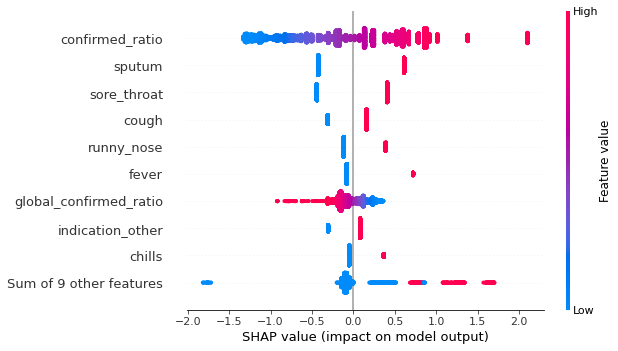

In [185]:
shap.plots.beeswarm(shap_values)

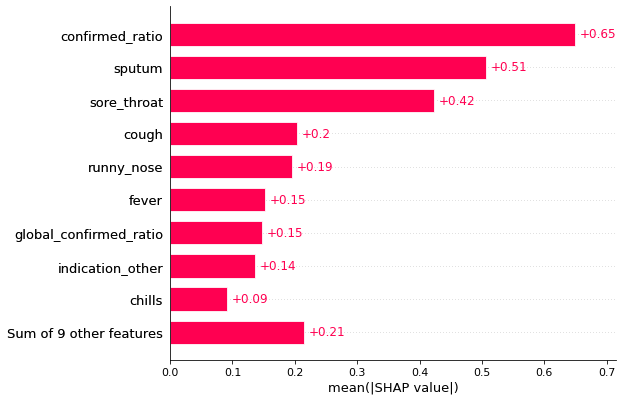

In [186]:
shap.plots.bar(shap_values)

In [187]:
shap.initjs()
shap.plots.force(shap_values[0])

In [188]:
# shap.plots.force(shap_values)

In [189]:
pred = logistic_clf.predict(test_input)

In [190]:
accuracy_score(test_gt, pred)

0.8014199655765921

accuracy 0.8014
precision 0.8929
recall 0.8427
f1-score 0.8671
[[1429  722]
 [1124 6021]]


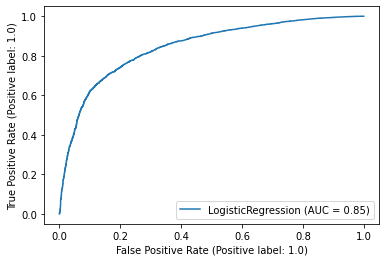

In [191]:
display_performance(logistic_clf, pred, test_input, test_gt)

In [192]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc = nn.Linear(in_features=16, out_features=1)
        self.activation = nn.Sigmoid()
        
    def forward(self, x):
        x = self.fc(x)
        x = self.activation(x)
        x = x.reshape(-1, 1)
        return x


In [193]:
net = Net()
print(net)
print(net.fc.weight, net.fc.bias)

device = 'cpu'
optimizer = optim.Adam(net.parameters(), lr=0.1)
criterion = nn.BCELoss()

Net(
  (fc): Linear(in_features=16, out_features=1, bias=True)
  (activation): Sigmoid()
)
Parameter containing:
tensor([[ 0.0604,  0.1652, -0.2021, -0.2239,  0.1529, -0.0612,  0.1772, -0.1741,
         -0.1978,  0.2003, -0.1850, -0.1236,  0.1341, -0.2195, -0.2342, -0.0179]],
       requires_grad=True) Parameter containing:
tensor([0.1898], requires_grad=True)


In [194]:
class ShineDataset(Dataset):
    def __init__(self, input_data, gt, transform=None, target_transform=None):
        self.input_data = input_data
        self.gt = gt
        self.transform = transform
        self.target_transform = target_transform
    
    def __len__(self):
        return len(self.input_data)
    
    def __getitem__(self, idx):
        return self.input_data[idx], self.gt[idx]

In [195]:
def plot_roc_curve_for_dnn(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [196]:
training_data = ShineDataset(torch.Tensor(train_input), torch.Tensor(train_gt.reshape(-1, 1)))
valid_data = ShineDataset(torch.Tensor(test_input), torch.Tensor(test_gt.reshape(-1, 1)))

train_dataloader = DataLoader(training_data, batch_size = 128, shuffle=False)
valid_dataloader = DataLoader(valid_data, batch_size=64, shuffle=False)

In [197]:
train_input.shape

(13718, 18)

In [198]:
# train_running_loss = 0.0
# num_epochs = 3

# train_history = []
# val_history = []

# for epoch in tqdm(range(num_epochs)):
#     net.train()
#     train_losses = []
#     for train_inputs, train_labels in tqdm(train_dataloader):
#         train_inputs = torch.unsqueeze(train_inputs, 1)
#         train_inputs = train_inputs.to(device)
#         train_labels = train_labels.to(device)
        
#         optimizer.zero_grad()
        
#         train_outputs = net(train_inputs)
#         train_loss = criterion(train_outputs, train_labels)
#         train_loss.backward()
#         optimizer.step()
#         train_losses.append(train_loss) 
#         print('Done. Train loss:{}'.format(train_loss))
    


In [199]:
# train_running_loss = 0.0
# num_epochs = 100

# train_history = []
# val_history = []

# for epoch in tqdm(range(num_epochs)):
#     net.train()
#     train_losses = []
#     for train_inputs, train_labels in tqdm(train_dataloader):
#         train_inputs = torch.unsqueeze(train_inputs, 1)
#         train_inputs = train_inputs.to(device)
#         train_labels = train_labels.to(device)

#         optimizer.zero_grad()
        
#         train_outputs = net(train_inputs)
#         train_outputs = nn.functional.sigmoid(train_outputs)
#         train_loss = criterion(train_outputs, train_labels)
#         train_loss.backward()
#         optimizer.step()
#         train_losses.append(train_loss)
    
#     net.eval()
    ㅇ
#     val_losses = []
#     val_all_outputs = []
#     val_all_labels = []
#     for val_inputs, val_labels in valid_dataloader:
#         val_inputs = torch.unsqueeze(val_inputs, 1)
#         val_outputs = net(torch.Tensor(val_inputs).to(device))
#         val_outputs = nn.functional.sigmoid(val_outputs)

#         val_loss_on_batch = criterion(val_outputs, val_labels.to(device))
#         val_losses.append(val_loss_on_batch)
#         val_all_outputs.append(val_outputs.cpu().detach().numpy())
#         val_all_labels.append(val_labels.cpu().detach().numpy())

#     val_all_outputs = np.concatenate(val_all_outputs, axis=0)
#     val_all_labels = np.concatenate(val_all_labels, axis=0)
#     print(val_all_outputs[:5], val_all_labels[:5])
#     auc = roc_auc_score(val_all_labels, val_all_outputs)    
    

#     total_val_loss = sum(val_losses) / len(valid_dataloader)
#     total_train_loss = sum(train_losses) / len(train_dataloader)
#     print('Done. Train loss:{}, Validation loss: {} VAL_AUC:{}'.format(total_train_loss, total_val_loss, auc))
    
#     fper, tper, thresholds = roc_curve(val_all_labels, val_all_outputs)
#     plot_roc_curve_for_dnn(fper, tper)
    
#     train_history.append(total_train_loss.cpu().detach().numpy())
#     val_history.append(total_val_loss.cpu().detach().numpy())